# Importing dependencies

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Data Loading

## Initializing constants

In [0]:
torch.cuda.is_available()

True

In [0]:
epochs = 5
image_size = 28
input_size = 100
batch_size = 64
num_channels = 1

In [0]:
dataset_train = torchvision.datasets.FashionMNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
# Change labels of dataset to real
dataset_train.targets = [1 for _ in range(len(dataset_train))]

In [0]:
labels_map = {0: 'Fake', 1: 'Real'}

In [0]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Convert into DataLoader

In [0]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(datasetloader)

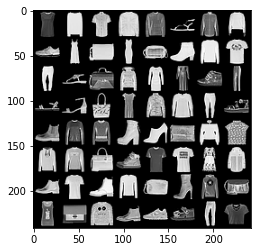

In [0]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [0]:
def initialize_weights(model):
  className = model.__class__.__name__
  if className.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif className.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [0]:
inp = 14
k = 4
s = 2
p = 1

(inp - 1) * s - 2 * p + 1 * (k - 1) + 0 + 1

28

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.main = nn.Sequential(
        nn.ConvTranspose2d(input_size, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # Shape [2 x 2]

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # Shape [4 x 4]

        nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # Shape [7 x 7]

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # Shape [14 x 14]

        nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
        nn.Tanh()
        # Shape [28 x 28]
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, inputs):
    return self.main(inputs)

In [0]:
generator = Generator()
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


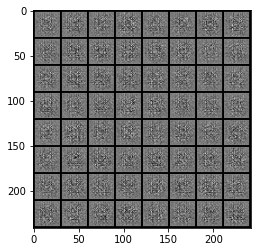

In [0]:
with torch.no_grad():
  # Note: model still in training mode
  noise = torch.randn(size=(batch_size, input_size, 1, 1)).cuda()
  output = generator(noise).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.main = nn.Sequential(
        nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # Shape [14 x 14]

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # Shape [7 x 7]

        nn.Conv2d(128, 256, 4, 1, 0, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # Shape [4 x 4]

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # Shape [2 x 2]

        nn.Conv2d(512, 1, 4, 2, 1, bias=False),
        nn.Sigmoid()
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, inputs):
    return self.main(inputs)

In [0]:
discriminator = Discriminator()
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(2

# Specifying Loss Function

In [0]:
BCE_loss = nn.BCELoss()

# Plotting output after each epoch

In [0]:
def plot_output():
  plt.clf()
  with torch.no_grad():
    input_noise = torch.randn(size=(current_batch_size, input_size, 1, 1)).cuda()
    
    generator.eval()
    test_images = generator(input_noise)
    generator.train()
  
  show_grid(torchvision.utils.make_grid(test_images.cpu(), normalize=True))

# Training

Epoch: 1 / 5
Discriminator Loss: 0.327, Generator Loss: 5.343


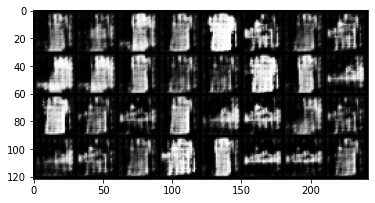

Epoch: 2 / 5
Discriminator Loss: 0.456, Generator Loss: 4.233


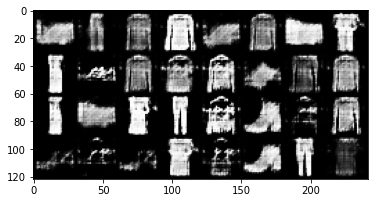

Epoch: 3 / 5
Discriminator Loss: 0.523, Generator Loss: 3.644


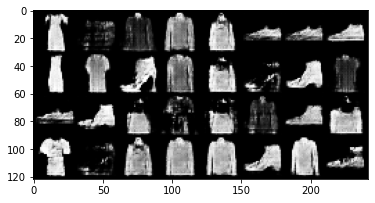

Epoch: 4 / 5
Discriminator Loss: 0.551, Generator Loss: 3.323


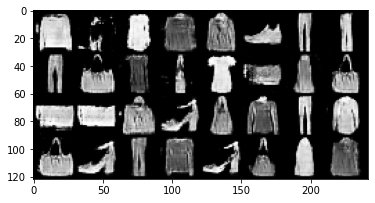

Epoch: 5 / 5
Discriminator Loss: 0.543, Generator Loss: 3.176


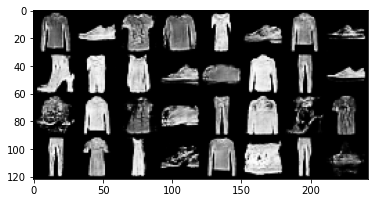

True

In [0]:
# Set tdqm for epoch progress
pbar = tqdm()


for epoch in range(epochs):
  print(f'Epoch: {epoch + 1} / {epochs}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_losses = []
  generator_losses = []
  for real_images, real_labels in datasetloader:
    # Clear gradients
    discriminator.zero_grad()

    current_batch_size = real_images.size()[0]
    fake_labels = torch.zeros(current_batch_size)

    real_images = real_images.cuda()
    real_labels = real_labels.type('torch.FloatTensor').cuda()
    fake_labels = fake_labels.cuda()


    # Loss for real images
    discriminator_real_labels = discriminator(real_images).squeeze()
    discriminator_real_loss = BCE_loss(discriminator_real_labels, real_labels)

    # Generate fake images from Generator
    input_noise = torch.randn(size=(current_batch_size, input_size, 1, 1))
    input_noise = input_noise.cuda()
    generated_images = generator(input_noise)

    # Loss for fake images
    discriminator_generated_labels = discriminator(generated_images).squeeze()
    discriminator_fake_loss = BCE_loss(discriminator_generated_labels, fake_labels)

    # Training Discriminator
    discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
    discriminator_total_loss.backward()
    discriminator.optimizer.step()
    discriminator_losses.append(discriminator_total_loss)

    # Training Generator
    generator.zero_grad()
    input_noise = torch.randn(size=(current_batch_size, input_size, 1, 1))
    input_noise = input_noise.cuda()
    generated_images = generator(input_noise)
    discriminator_generated_labels = discriminator(generated_images).squeeze()
    generator_loss = BCE_loss(discriminator_generated_labels, real_labels)
    generator_loss.backward()
    generator.optimizer.step()
    generator_losses.append(generator_loss)

    # Update tqdm
    pbar.update()

  print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(torch.mean(torch.FloatTensor(discriminator_losses)), torch.mean(torch.FloatTensor(generator_losses))))
  plot_output()

pbar.refresh()